In [27]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
import os
from time import time
from pprint import pprint
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import re
import collections
from pathlib import Path
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras import models as md
from keras import layers
import gensim
from gensim import corpora, models, similarities
import preprocessor as p
import os
#cancel diplay tensorflow warning
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'




#Function to train a multi-class model
def deep_model(model, X_train, y_train, X_valid, y_valid):
  
    model.compile(optimizer='adam'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    return history

#function to display the evaluation metric
def eval_metric(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()
    
#funcion to test the model
def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    
    return results


In [9]:
path = 'data/df_model.p'
tweet = pd.read_pickle(path)
tweet.head()

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,sentiment,origin_text,likes,retweets,clean_text
557219,20,1,1,0,1,1,0,neutral,5 ways Internet of things will create new opportunities for Indian businesses!Read here http://t.co/NiroT9Xa9I #DigitalUniverseIN @emcindia,0,0,way internet thing creat new opportun indian busi read digitaluniversein
5084791,21,1,4,0,0,2,0,neutral,"As #bigdata, #cloud, and #IoT usage increases, so do #security concerns https://t.co/lXwuN7CP6s via @ITProPortal https://t.co/8KPv2ZbcuY",0,0,bigdata cloud iot usag increas secur concern
4330044,15,0,1,0,0,1,0,neutral,Hewlett Packard Enterprise Co Launches an Internet of Things Platform https://t.co/qf8qKwAhFs #iot,1,0,hewlett packard enterpris co launch internet thing platform iot
4846444,17,0,0,0,0,1,0,neutral,"The Internet of Things is about to disrupt the digital economy, report says https://t.co/RFWzNYvNY1",0,1,internet thing disrupt digit economi report say
1338071,14,0,2,0,0,1,0,neutral,How the #InternetOfThings is changing the World around Us http://t.co/iPz10oo7hc … #IoT,0,0,internetofth chang world around us iot


In [11]:
tweet = tweet[['clean_text', 'sentiment']]
#spliting train-test
X_train, X_test, y_train, y_test = train_test_split(tweet.clean_text, tweet.sentiment, test_size=0.33, random_state=37)

In [13]:
NB_WORDS = 1000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 10  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 24 # Maximum number of words in a sequence
REG = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'

In [12]:
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 33144
# Test data samples: 16325


In [16]:
#tokenize tweet text
tk = Tokenizer(num_words=NB_WORDS,filters=REG,lower=True, split=" ")
tk.fit_on_texts(X_train)
#convert text into sequence
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)
#normalise the length of each sequence
seq_lengths = X_train.apply(lambda x: len(x.split(' ')))
print(seq_lengths.describe())

count    33144.000000
mean     8.463674    
std      7.418723    
min      1.000000    
25%      6.000000    
50%      8.000000    
75%      10.000000   
max      828.000000  
Name: clean_text, dtype: float64


In [17]:
MAX_LEN = 1000
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=MAX_LEN)

In [21]:
#convert sentiment to sequence
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

In [23]:
#split off the validation data
X_train_emb, X_valid_emb, y_train_emb,y_valid_emb = train_test_split(X_train_seq_trunc,
                               y_train_oh, 
                               test_size=0.33, 
                               random_state=37)
assert X_valid_emb.shape[0] == y_valid_emb.shape[0]
assert X_train_emb.shape[0] == y_train_emb.shape[0]

In [24]:
print('Shape of validation set:',X_valid_emb.shape)

Shape of validation set: (10938, 1000)


In [25]:
#creation of sequential keras model
emb_model = md.Sequential()
emb_model.add(layers.Embedding(NB_WORDS, 8, input_length=MAX_LEN))
emb_model.add(layers.Flatten())
emb_model.add(layers.Dense(3, activation='softmax'))
emb_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
emb_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 8)           8000      
_________________________________________________________________
flatten_1 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 24003     
Total params: 32,003
Trainable params: 32,003
Non-trainable params: 0
_________________________________________________________________


In [28]:
emb_history = deep_model(emb_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)

In [29]:
print(emb_history.history['acc'][-1])

0.748131135901


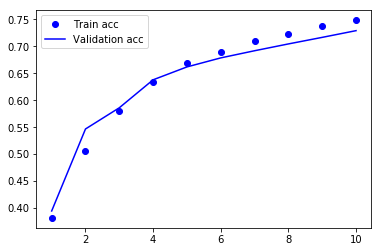

None


In [30]:
print(eval_metric(emb_history, 'acc'))

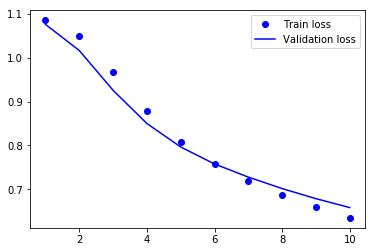

None


In [31]:
print(eval_metric(emb_history, 'loss'))

In [32]:
emb_results = test_model(emb_model, X_train_seq_trunc, y_train_oh, X_test_seq_trunc, y_test_oh, 6)

16325/16325 [==============================] - 1s 39us/step


In [33]:
print('Test accuracy of word embeddings model: {0:.2f}%'.format(emb_results[1]*100))

Test accuracy of word embeddings model: 77.56%


In [35]:
print('Test accuracy of word embeddings model: {0:.2f}'.format(emb_results[1]))

Test accuracy of word embeddings model: 0.78
